In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
from caiman.source_extraction.cnmf import cnmf
from scipy.stats import zscore
from scipy import io
from scipy.stats import percentileofscore

In [1]:
mouse_id = 1637
session_date = '2024-10-11T15_17_23'

In [4]:
def save_mat_file(data, save_folder, save_filename):
    """
    Save the given data to a specified folder with the provided filename in MATLAB format (.mat).
    
    Parameters:
    - data: dictionary containing data to save
    - save_folder: folder where the .mat file should be saved
    - save_filename: filename for the saved .mat file
    """
    os.makedirs(save_folder, exist_ok=True)  # Create the folder if it doesn't exist
    save_path = os.path.join(save_folder, save_filename)
    
    try:
        io.savemat(save_path, data)
        print(f"MAT file saved to: {save_path}")
    except Exception as e:
        print(f"Failed to save MAT file: {e}")

In [ ]:
base_path = f'/media/toor/T7Shield/Mouse1637/Linear/{session_date}/caiman/'
hdf5_path = os.path.join(base_path, 'caiman_results.hdf5')

# Load the saved results
cnmf_refit = cnmf.load_CNMF(hdf5_path)

# Get the correlation image for visualization
correlation_image = cnmf_refit.estimates.Cn
print(f"Successfully loaded data from {hdf5_path}.")
    
save_folder = "/media/toor/T7Shield/Mouse1637/Linear/Cellreg_processed"
os.makedirs(save_folder, exist_ok=True)  # Create folder if it doesn't exist
print(f"Date will be saved in: {save_folder}.")

Successfully loaded data from /media/toor/T7Shield/Mouse1637/Linear/2024-10-11T15_17_23/caiman/caiman_results.hdf5.
Date will be saved in: /media/toor/T7Shield/Mouse1637/Linear/Cellreg_processed.


In [7]:
F_dff_good = cnmf_refit.estimates.F_dff[cnmf_refit.estimates.idx_components]
F_dff_good.shape

(667, 22508)

In [ ]:
F_dff = cnmf_refit.estimates.F_dff
idx_accepted = cnmf_refit.estimates.idx_components

# Extract ∆F/F for the accepted components
F_dff_accepted = F_dff[idx_accepted, :]  # Shape: (number of accepted cells, time)

# Z-score normalization along each component (neuron)
F_dff_accepted_zscore = zscore(F_dff_accepted, axis=1)

# Assuming you have the frame rate of your video
frame_rate = 25 
time_in_seconds = np.arange(F_dff.shape[1]) / frame_rate  # Convert frames to seconds

In [9]:
# Save .npy file
filename = f"{mouse_id}_{session_date}_Fdff_accepted.npy"
save_path = os.path.join(save_folder, filename)
np.save(save_path, F_dff_good)
print(f"F_dff_good saved to: {save_path}")

F_dff_good saved to: /media/toor/T7Shield/Mouse1637/Linear/Cellreg_processed/1637_2024-10-11T15_17_23_Fdff_accepted.npy


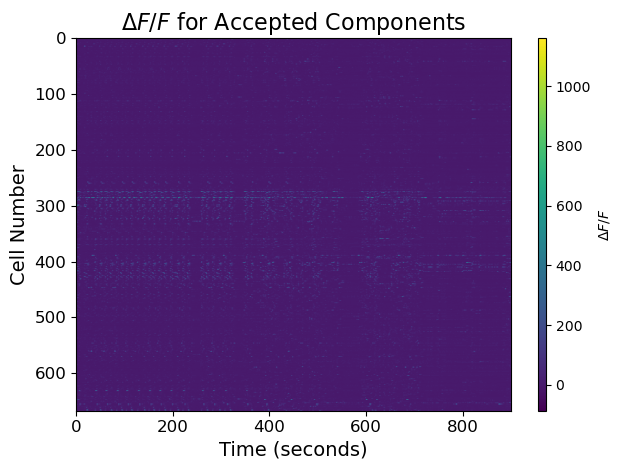

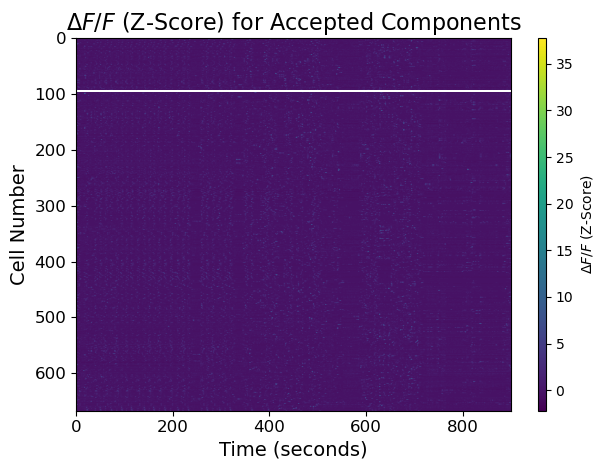

In [10]:
# Plotting Original ∆F/F Heatmap
plt.imshow(F_dff_accepted, aspect='auto', cmap='viridis', extent=[time_in_seconds[0], time_in_seconds[-1], len(idx_accepted), 0])
plt.xlabel('Time (seconds)', fontsize=14)
plt.ylabel('Cell Number', fontsize=14)
plt.title('$\Delta F/F$ for Accepted Components', fontsize=16)
plt.colorbar(label='$\Delta F/F$', aspect=50)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
fig = plt.gcf()  # Get the current figure that contains the plot
plt.show()

# Plotting Z-scored ∆F/F Heatmap
plt.imshow(F_dff_accepted_zscore, aspect='auto', cmap='viridis', extent=[time_in_seconds[0], time_in_seconds[-1], len(idx_accepted), 0])
plt.xlabel('Time (seconds)', fontsize=14)
plt.ylabel('Cell Number', fontsize=14)
plt.title('$\Delta F/F$ (Z-Score) for Accepted Components', fontsize=16)
plt.colorbar(label='$\Delta F/F$ (Z-Score)', aspect=50)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
fig = plt.gcf()  # Get the current figure that contains the z-scored plot
plt.show()

In [11]:
A = cnmf_refit.estimates.A  # This is a sparse matrix of shape (M*K, N)

# Get indices of accepted components
idx_accepted = cnmf_refit.estimates.idx_components

# Extract the spatial footprints of the accepted components
A_accepted = A[:, idx_accepted]  # This will still be a sparse matrix

print("Shape of A (all components):", A.shape)  # (M*K, N)
print("Shape of A (accepted components):", A_accepted.shape)  # (M*K, number of accepted components)

Shape of A (all components): (307200, 1115)
Shape of A (accepted components): (307200, 667)


Text(0.5, 1.0, 'Footprint 12')

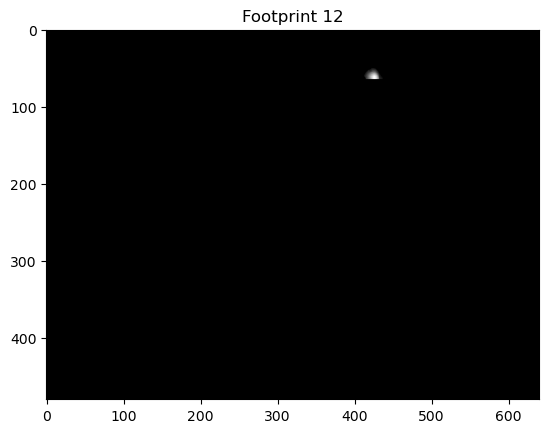

In [12]:
# Plot an example footprint
idx_accepted = cnmf_refit.estimates.idx_components
dims = cnmf_refit.dims
idx_to_plot = 5
component_number = idx_accepted[idx_to_plot]
component_footprint = np.reshape(cnmf_refit.estimates.A[:, component_number].toarray(), dims, order='F')
plt.figure(); 
plt.imshow(component_footprint, cmap='gray')
plt.title(f'Footprint {component_number}')

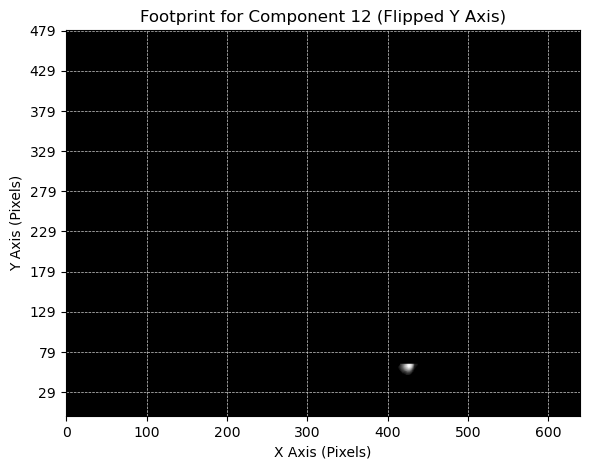

In [13]:
# Reshape the footprint back to its original dimensions
component_footprint = np.reshape(cnmf_refit.estimates.A[:, component_number].toarray(), dims, order='F')

# Flip the matrix along the y-axis to change the actual spatial values
component_footprint_flipped = np.flipud(component_footprint)  # This flips the data vertically (top to bottom)

# Plot the flipped footprint
plt.figure(figsize=(6, 5))
plt.imshow(component_footprint_flipped, cmap='gray', origin='lower')  # Use 'lower' to place (0, 0) in bottom-left
plt.title(f'Footprint for Component {component_number} (Flipped Y Axis)')
plt.xlabel('X Axis (Pixels)')
plt.ylabel('Y Axis (Pixels)')
ax = plt.gca()
ax.invert_yaxis()  # Make the y-axis origin align visually with the image (bottom to top)
ax.set_yticks(np.arange(0, dims[0], step=50))  # Adjust this step size if needed
ax.set_yticklabels(np.arange(dims[0] - 1, -1, -50))  # Properly reflect the flipped coordinate values
plt.grid(visible=True, color='lightgray', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

In [14]:
# Get dimensions of original field of view
M, K = cnmf_refit.dims

# Initialize a new matrix for storing the flipped footprints for all accepted components
N_accepted = len(idx_accepted)
flipped_footprints = np.zeros((N_accepted, M, K))

# Iterate over all accepted components and flip their footprints
for i, component_number in enumerate(idx_accepted):
    # Get the current footprint and reshape it to original dimensions
    component_footprint = np.reshape(cnmf_refit.estimates.A[:, component_number].toarray(), (M, K), order='F')
    
    # Flip the matrix along the y-axis
    component_footprint_flipped = np.flipud(component_footprint)  # This flips the data vertically
    
    # Store the flipped footprint in the new matrix
    flipped_footprints[i, :, :] = component_footprint_flipped


In [15]:
data_to_save = {
    'flipped_footprints': flipped_footprints,  # The NxMxK matrix with flipped footprints
    'dims': (M, K),  # Original field of view dimensions
    'N_accepted': N_accepted,  # Number of accepted components
}

# Define the save folder and filename
save_filename = f"{mouse_id}_{session_date}_flipped_footprints.mat"

# Save to a MATLAB file using the save function
save_mat_file(data_to_save, save_folder, save_filename)

MAT file saved to: /media/toor/T7Shield/Mouse1637/Linear/Cellreg_processed/1637_2024-10-11T15_17_23_flipped_footprints.mat


### For loop for all sessions in directory

In [4]:
mouse_id = 1637
directory_path = "/media/toor/T7Shield/Mouse1637/Linear"
session_dates = [name for name in os.listdir(directory_path) if os.path.isdir(os.path.join(directory_path, name))]
if 'Cellreg_processed' in session_dates:
    session_dates.remove('Cellreg_processed')
frame_rate = 25 

save_folder = "/media/toor/T7Shield/Mouse1637/Linear/Cellreg_processed"
os.makedirs(save_folder, exist_ok=True)  # Create folder if it doesn't exist
print(f"Date will be saved in: {save_folder}.")

Date will be saved in: /media/toor/T7Shield/Mouse1637/Linear/Cellreg_processed.


In [6]:
for session_date in session_dates:
    print(f"Processing session: {session_date}")
    base_path = f'/media/toor/T7Shield/Mouse1637/Linear/{session_date}/caiman/'
    hdf5_path = os.path.join(base_path, 'caiman_results.hdf5')

    # Load the saved results
    cnmf_refit = cnmf.load_CNMF(hdf5_path)
    print(f"Successfully loaded data from {hdf5_path}.")
    F_dff_good = cnmf_refit.estimates.F_dff[cnmf_refit.estimates.idx_components]
    F_dff = cnmf_refit.estimates.F_dff
    idx_accepted = cnmf_refit.estimates.idx_components

    # Extract ∆F/F for the accepted components
    F_dff_accepted = F_dff[idx_accepted, :]  # Shape: (number of accepted cells, time)

    # Save .npy file
    filename = f"{mouse_id}_{session_date}_Fdff_accepted.npy"
    save_path = os.path.join(save_folder, filename)
    if not os.path.exists(save_path):
        np.save(save_path, F_dff_good)
        print(f"F_dff_good.npy saved to: {save_path}")
    else:
        print(f"File already exists, skipping: {filename}")
    
    
   

    # # Extract the spatial footprints of the accepted components
    # A = cnmf_refit.estimates.A  # This is a sparse matrix of shape (M*K, N)
    # A_accepted = A[:, idx_accepted]  # This will still be a sparse matrix

    # print("Shape of A (all components):", A.shape)  # (M*K, N)
    # print("Shape of A (accepted components):", A_accepted.shape)  # (M*K, number of accepted components)

    # Get dimensions of original field of view
    M, K = cnmf_refit.dims

    # Initialize a new matrix for storing the flipped footprints for all accepted components
    N_accepted = len(idx_accepted)
    flipped_footprints = np.zeros((N_accepted, M, K))

    # Iterate over all accepted components and flip their footprints
    for i, component_number in enumerate(idx_accepted):
        # Get the current footprint and reshape it to original dimensions
        component_footprint = np.reshape(cnmf_refit.estimates.A[:, component_number].toarray(), (M, K), order='F')
        
        # Flip the matrix along the y-axis
        component_footprint_flipped = np.flipud(component_footprint)  # This flips the data vertically
        
        # Store the flipped footprint in the new matrix
        flipped_footprints[i, :, :] = component_footprint_flipped

    
    data_to_save = {
        'flipped_footprints': flipped_footprints,  # The NxMxK matrix with flipped footprints
        'dims': (M, K),  # Original field of view dimensions
        'N_accepted': N_accepted,  # Number of accepted components
    }
    save_filename = f"{mouse_id}_{session_date}_flipped_footprints.mat"

    if not os.path.exists(save_filename):
        save_mat_file(data_to_save, save_folder, save_filename)
        print(f"File saved: {filename}")
    else:
        print(f"File already exists, skipping: {filename}")

    

Processing session: 2024-06-03T11_49_24
Successfully loaded data from /media/toor/T7Shield/Mouse1637/Linear/2024-06-03T11_49_24/caiman/caiman_results.hdf5.
File already exists, skipping: 1637_2024-06-03T11_49_24_Fdff_accepted.npy
MAT file saved to: /media/toor/T7Shield/Mouse1637/Linear/Cellreg_processed/1637_2024-06-03T11_49_24_flipped_footprints.mat
File saved: 1637_2024-06-03T11_49_24_Fdff_accepted.npy
Processing session: 2024-05-28T12_36_37
Successfully loaded data from /media/toor/T7Shield/Mouse1637/Linear/2024-05-28T12_36_37/caiman/caiman_results.hdf5.
File already exists, skipping: 1637_2024-05-28T12_36_37_Fdff_accepted.npy
MAT file saved to: /media/toor/T7Shield/Mouse1637/Linear/Cellreg_processed/1637_2024-05-28T12_36_37_flipped_footprints.mat
File saved: 1637_2024-05-28T12_36_37_Fdff_accepted.npy
Processing session: 2024-06-07T12_55_13
Successfully loaded data from /media/toor/T7Shield/Mouse1637/Linear/2024-06-07T12_55_13/caiman/caiman_results.hdf5.
File already exists, skippin

In [9]:
save_folder = "/media/toor/T7Shield/Mouse1637/Linear/Cellreg_processed"
# Load the saved results
hdf5_path = "/media/toor/SeagatePortableDrive/AGING_MICE/Mouse1637/BaselineRecordings/miniscopeBaseline2024-12-13T12_55_37/caiman03/caiman_results.hdf5"
cnmf_refit = cnmf.load_CNMF(hdf5_path)
print(f"Successfully loaded data from {hdf5_path}.")
F_dff_good = cnmf_refit.estimates.F_dff[cnmf_refit.estimates.idx_components]
F_dff = cnmf_refit.estimates.F_dff
idx_accepted = cnmf_refit.estimates.idx_components

# Extract ∆F/F for the accepted components
F_dff_accepted = F_dff[idx_accepted, :]  # Shape: (number of accepted cells, time)

# Save .npy file
filename = f"BaselineRecordings03_Fdff_accepted.npy"
save_path = os.path.join(save_folder, filename)
if not os.path.exists(save_path):
    np.save(save_path, F_dff_good)
    print(f"F_dff_good.npy saved to: {save_path}")
else:
    print(f"File already exists, skipping: {filename}")




# # Extract the spatial footprints of the accepted components
# A = cnmf_refit.estimates.A  # This is a sparse matrix of shape (M*K, N)
# A_accepted = A[:, idx_accepted]  # This will still be a sparse matrix

# print("Shape of A (all components):", A.shape)  # (M*K, N)
# print("Shape of A (accepted components):", A_accepted.shape)  # (M*K, number of accepted components)

# Get dimensions of original field of view
M, K = cnmf_refit.dims

# Initialize a new matrix for storing the flipped footprints for all accepted components
N_accepted = len(idx_accepted)
flipped_footprints = np.zeros((N_accepted, M, K))

# Iterate over all accepted components and flip their footprints
for i, component_number in enumerate(idx_accepted):
    # Get the current footprint and reshape it to original dimensions
    component_footprint = np.reshape(cnmf_refit.estimates.A[:, component_number].toarray(), (M, K), order='F')
    
    # Flip the matrix along the y-axis
    component_footprint_flipped = np.flipud(component_footprint)  # This flips the data vertically
    
    # Store the flipped footprint in the new matrix
    flipped_footprints[i, :, :] = component_footprint_flipped


data_to_save = {
    'flipped_footprints': flipped_footprints,  # The NxMxK matrix with flipped footprints
    'dims': (M, K),  # Original field of view dimensions
    'N_accepted': N_accepted,  # Number of accepted components
}
save_filename = f"BaselineRecordings03_flipped_footprints.mat"

if not os.path.exists(save_filename):
    save_mat_file(data_to_save, save_folder, save_filename)
    print(f"File saved: {filename}")
else:
    print(f"File already exists, skipping: {filename}")


Successfully loaded data from /media/toor/SeagatePortableDrive/AGING_MICE/Mouse1637/BaselineRecordings/miniscopeBaseline2024-12-13T12_55_37/caiman03/caiman_results.hdf5.
F_dff_good.npy saved to: /media/toor/T7Shield/Mouse1637/Linear/Cellreg_processed/BaselineRecordings03_Fdff_accepted.npy
MAT file saved to: /media/toor/T7Shield/Mouse1637/Linear/Cellreg_processed/BaselineRecordings03_flipped_footprints.mat
File saved: BaselineRecordings03_Fdff_accepted.npy
